In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_n, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

provider = startup(hub='ibm-q-melbourne', group='unimelb', project='hub')

In [9]:
import pickle
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Local modules
from utilities import check_provider, IBM_startup, bit_str_list
from graphstate import GraphState, calc_n, plot_cxerr_corr

hub = "ibm-q-melbourne"
group = "unimelb"
project = "exploratory"
backend_name = 'ibm_seattle'
hgp = f"{hub}/{group}/{project}"

provider = IBM_startup()
backend = provider.get_backend(backend_name, instance=hgp)

Account enabled


In [13]:
from math import pi

def ideal_negativity(theta):
    return (1/2)*np.sin(theta/2)

def calc_negativities(rho_list, neighbour = False):
    n_list = []
    nexp = len(rho_list)
    for i in range(nexp):
        if neighbour is False:
            negativities = {angle: {} for angle in rho_list[i].keys()}
            for angle, rho in rho_list[i].items():
                n = calc_n(rho)
                negativities[angle] = n
        
        else:
            n = len(next(iter(rho_list[0])))
            negativities = {bn: {angle: {} for angle in rho_list[i][next(iter(rho_list[i]))].keys()} 
                            for bn in bit_str_list(n)}
            for bn, angles_dict in rho_list[i].items():
                for angle, rho in angles_dict.items():
                    negativities[bn][angle] = calc_n(rho)
        n_list.append(negativities)
    return n_list

def calc_n_mean(n_list):
    """Calculate mean negativity dict from lists of negativity dicts"""

    angles = n_list[0]['000'].keys()
    N = len(n_list)

    n_dict = {angle: [[n_list[i][neighbour][angle] for neighbour in n_list[i].keys()] 
                      for i in range(N)] 
              for angle in angles}
    
    data = {angle: [np.mean(rep) for rep in ls] for angle, ls in n_dict.items()}#n_mean = {'(0,1)':0.44,'(1,2)':0.23} where the negativities are averaged
    n_mean = {angle: np.mean(ls) for angle, ls in data.items()}
    n_std = {angle: np.std(ls)/np.sqrt(len(ls))  for angle, ls in data.items()}#n_std are the standard deviation for each pair of qubits

    return n_mean, n_std, data

def plot_negativities_vs_angle(backend, n_list, nmit_list=None, figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    angles = n_list[0]['000'].keys()
    n_mean, n_std, data = calc_n_mean(n_list)

    # Convert into array for plotting
    X = np.array([angle for angle in angles])
    Y0 = np.fromiter(n_mean.values(), float)
    Y0err = np.fromiter(n_std.values(), float)*2

    # If mitigated results are included
    try:
        nmit_mean, nmit_std, data_mit = calc_n_mean(nmit_list)

        Y1 = np.fromiter(nmit_mean.values(), float)
        Y1err = np.fromiter(nmit_std.values(), float)*2
    except:
        pass

    # Plot
    ax.errorbar(X, Y0, yerr=Y0err, capsize=3, fmt='.', c='r', linestyle = 'solid', label=f'No QREM')
    
    rep = len(n_list)
    for  i in range(rep):
        ax.plot(X, [v[i] for v in data.values()], marker='.', color = 'pink', linestyle = 'dashed')
        
    try:
        ax.errorbar(X, Y1, yerr=Y1err, capsize=3, fmt='.', c='b', linestyle = 'solid', label=f'QREM')
        for  i in range(rep):
            ax.plot(X, [v[i] for v in data_mit.values()], marker='.', color = 'aqua', linestyle = 'dashed')
            
    except:
        pass
    
    fit_ideal_theta = np.linspace(0,pi,1000)
    fit_ideal_negativity = ideal_negativity(fit_ideal_theta)
    ax.plot(fit_ideal_theta, fit_ideal_negativity, color = 'black', linestyle = 'solid',
            label = 'Partially Entangled GraphState Ideal Negativity')
    
    l = ax.fill_between(fit_ideal_theta, fit_ideal_negativity, 0.5)
    l.set_facecolors([0.5,0.5,0.8,0.3])
    # Fig params
    ax.set_xticks(np.arange(0, pi+pi/6, pi/6), ['0','π/6','π/3','π/2','2π/3','5π/6','π'])
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    #ax.tick_params(axis='x', labelrotation=90)
    ax.annotate(r"$N=\frac{1}{2}\sin \left( \frac{\theta }{2} \right)$", (pi/6, .25))
    ax.grid()
    ax.legend()

    ax.set_xlabel("Controlled Z-rotation angle", fontsize=15)
    ax.set_ylabel("Average Negativity",fontsize=15)
    #ax.set_title(f"Native-graph state negativities ({backend.name()})")
    ax.set_title(f'{backend.name} Qubit Pair 383-384', fontsize=15)

    return fig

In [8]:
a = [0,1,2,3,5]
b = [1,3]
c = list(set(a)-set(b))
print(c)

[0, 2, 5]


In [15]:
#backend = provider.get_backend('ibmq_kolkata')
graphstate = GraphState(backend, qubits_to_connect=[5,8,9,11])
graphstate.gen_partial_angled_qst_circuits(reduced_qubits=[8,9], angle_counts=10)
print(graphstate.name_list)
#display(graphstate.partial_angled_qst_circuits['angle7']['XX'].draw('mpl'))
job = graphstate.run_partial_angled_qst_circuits(reps=2, shots=4096, qrem = True, sim= None)
print(job.job_id())
#result = job.result()

['angle0-XX', 'angle0-XY', 'angle0-XZ', 'angle0-YX', 'angle0-YY', 'angle0-YZ', 'angle0-ZX', 'angle0-ZY', 'angle0-ZZ', 'angle1-XX', 'angle1-XY', 'angle1-XZ', 'angle1-YX', 'angle1-YY', 'angle1-YZ', 'angle1-ZX', 'angle1-ZY', 'angle1-ZZ', 'angle2-XX', 'angle2-XY', 'angle2-XZ', 'angle2-YX', 'angle2-YY', 'angle2-YZ', 'angle2-ZX', 'angle2-ZY', 'angle2-ZZ', 'angle3-XX', 'angle3-XY', 'angle3-XZ', 'angle3-YX', 'angle3-YY', 'angle3-YZ', 'angle3-ZX', 'angle3-ZY', 'angle3-ZZ', 'angle4-XX', 'angle4-XY', 'angle4-XZ', 'angle4-YX', 'angle4-YY', 'angle4-YZ', 'angle4-ZX', 'angle4-ZY', 'angle4-ZZ', 'angle5-XX', 'angle5-XY', 'angle5-XZ', 'angle5-YX', 'angle5-YY', 'angle5-YZ', 'angle5-ZX', 'angle5-ZY', 'angle5-ZZ', 'angle6-XX', 'angle6-XY', 'angle6-XZ', 'angle6-YX', 'angle6-YY', 'angle6-YZ', 'angle6-ZX', 'angle6-ZY', 'angle6-ZZ', 'angle7-XX', 'angle7-XY', 'angle7-XZ', 'angle7-YX', 'angle7-YY', 'angle7-YZ', 'angle7-ZX', 'angle7-ZY', 'angle7-ZZ', 'angle8-XX', 'angle8-XY', 'angle8-XZ', 'angle8-YX', 'angle8-YY'

In [11]:
#ibm_sherbrooke
# qubit 19, 20 (100% ECR error) (0.28, 0.31, 0.044,0.033,0.007 readout error) (with neighbours binned)
#job = provider.backend.retrieve_job('ci5gjr5ejm3lf1e4e28g')
#result = job.result()
#ibm_brisbane
# qubit 77,78 (0.023 ECR error) (0.07, 0.13, 0.01,0.02,0.01 readout error) (with neighbours binned)
#job = provider.backend.retrieve_job('ci63rum8t9vighs2c810')

#ibm_seattle
#qubit 112,113 (0.025 ECR error) (0.027, 0.071,0.41, 0.083, 0.25 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cin1lellipn668d3nukg')

#2 tries with 2+2 reps, qubit 113,114 (0.018 ECR error) (0.083, 0.072, 0.41, 0.25, 0.12 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cin3n9t5ear1k1hv2od0')
#job2 = provider.backend.retrieve_job('')
#result1 = job1.result()
#result2 = job2.result()

#2 tries with 2+2 reps, qubit 383,384 (0.01 ECR error) (0.2, 0.29, 0.045, 0.047, 0.4 readout error) (with neighbours binned)
job1 = provider.backend.retrieve_job('cin514muepl060sd00s0')
job2 = provider.backend.retrieve_job('cin5aceuepl060sd76gg')

#2 tries with 2+2 reps, qubit 44,45 (0.01 ECR error) (0.2, 0.29, 0.045, 0.047, 0.4 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('')
#job2 = provider.backend.retrieve_job('')

#ibm_brisbane
#2 tries with 2+2 reps, qubit 77,78 (0.0089 ECR error) (0.01,0.021,0.044,0.13,0.0086 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cj4g7ggl9m0cics3tvf0')
#job2 = provider.backend.retrieve_job('cj4g84unq2dtrqsbtda0')

#ibmq_kolkata
#2 tries with 2+2 reps, qubit 11,14 (1 ECR error) (0.037,0.13,0.0079,0.083,0.0088 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cj4pr76nq2dtrqsl9f90')
#job2 = provider.backend.retrieve_job('cj4proklik66u2g9fkl0')

#ibm_algiers
#2 tries with 2+2 reps, qubit 16,19 (1 CX error) (0.017,0.47,0.12,0.028,0.0086 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cj4pvrgl9m0cicsd8u80')
#job2 = provider.backend.retrieve_job('cj4q0ek3bgbqjl9fn4gg')

#ibm_cairo
#2 tries with 2+2 reps, qubit 8,9 (0.0059 CX error) (0.009,0.002,0.14,0.0061 readout error) (with neighbours binned)
#job1 = provider.backend.retrieve_job('cj4qdk8l9m0cicsdkg5g')
#job2 = provider.backend.retrieve_job('cj4qdvmnq2dtrqslpgqg')

result1 = job1.result()
result2 = job2.result()


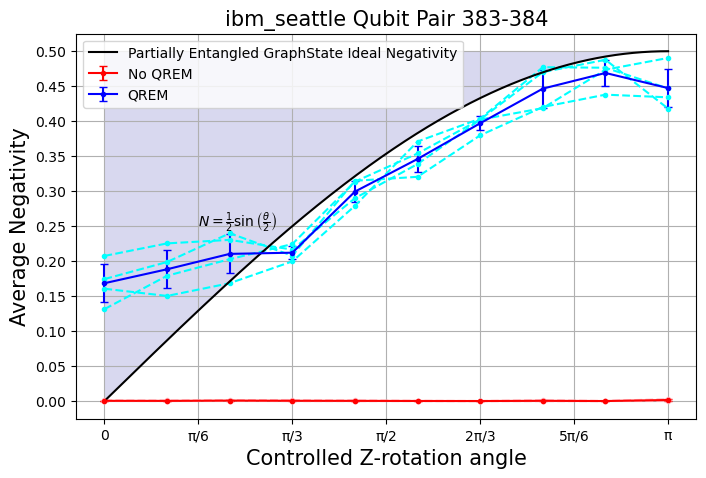

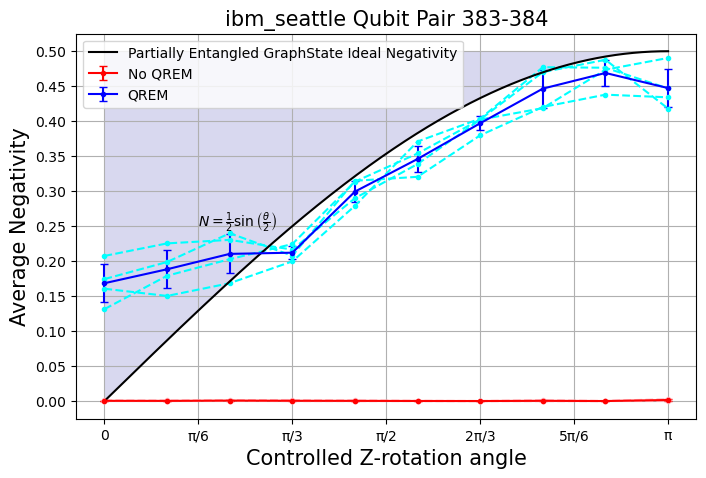

In [14]:
#graphstate = GraphState(backend, qubits_to_connect=[5,8,9,11])
graphstate = GraphState(backend, qubits_to_connect=[382,383,384,385,402])
rho_list1 = graphstate.recon_density_mats_from_partial_angled(result1,apply_mit=False,angle_counts=10,
                                                             reduced_qubits=[383,384])
rho_list2 = graphstate.recon_density_mats_from_partial_angled(result2,apply_mit=False,angle_counts=10,
                                                             reduced_qubits=[383,384])

rho_list_mit1 = graphstate.recon_density_mats_from_partial_angled(result1,apply_mit=True,angle_counts=10,
                                                                 reduced_qubits=[383,384])
rho_list_mit2 = graphstate.recon_density_mats_from_partial_angled(result2,apply_mit=True,angle_counts=10,
                                                                 reduced_qubits=[383,384])

n_list1 = calc_negativities(rho_list1, neighbour=True)
n_list2 = calc_negativities(rho_list2, neighbour=True)
nmit_list1 = calc_negativities(rho_list_mit1, neighbour=True)
nmit_list2 = calc_negativities(rho_list_mit2, neighbour=True)
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#n_list000 = [bn_dict['000'] for bn_dict in n_list]
#nmit_list000 = [bn_dict['000'] for bn_dict in nmit_list]

display(plot_negativities_vs_angle(backend, n_list, nmit_list))

In [36]:
job = provider.backend.retrieve_job('ci63rum8t9vighs2c810')
result = job.result()
#print(result.to_dict()['results'][-3]['header']['name'][-1])
print(result.results[-3].header.name)

angle9-ZZ-0


{0.0: array([[0.24951172+4.04686457e-18j, 0.22200521+6.26627604e-03j,
        0.19958496-5.73730469e-03j, 0.17749023-1.53808594e-02j],
       [0.22200521-6.26627604e-03j, 0.28450521+1.34708571e-18j,
        0.16992188-2.29492188e-02j, 0.22839355-2.67333984e-02j],
       [0.19958496+5.73730469e-03j, 0.16992188+2.29492188e-02j,
        0.22965495+1.45845143e-18j, 0.18929036+2.60416667e-03j],
       [0.17749023+1.53808594e-02j, 0.22839355+2.67333984e-02j,
        0.18929036-2.60416667e-03j, 0.23632813+3.55593915e-18j]]), 0.3490658503988659: array([[0.27001953+1.06907255e-18j, 0.21594238-1.18001302e-02j,
        0.19970703-3.72721354e-02j, 0.14648438-1.03393555e-01j],
       [0.21594238+1.18001302e-02j, 0.25805664+3.01764736e-18j,
        0.16625977-2.06298828e-02j, 0.17724609-9.70865885e-02j],
       [0.19970703+3.72721354e-02j, 0.16625977+2.06298828e-02j,
        0.22900391+8.59477887e-19j, 0.17370605-5.40364583e-02j],
       [0.14648438+1.03393555e-01j, 0.17724609+9.70865885e-02j,
     

KeyError: '000'

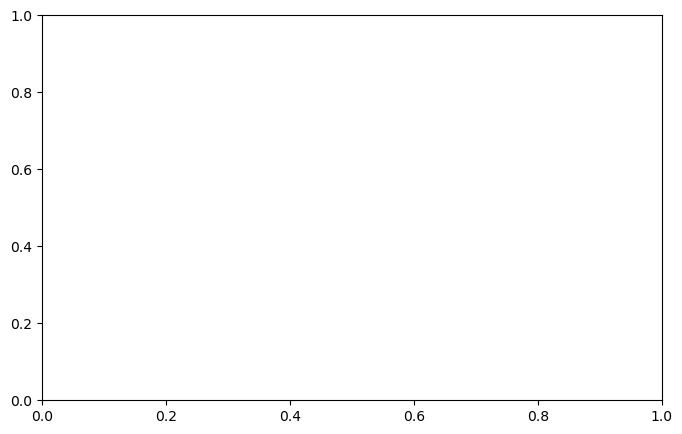

In [4]:
#ibm_hanoi
# qubit 5,8 (100% ECR error) (0.0067, 0.0146 readout error)
#job = provider.backend.retrieve_job('ci0is213lqnvrkvp9k2g')
# qubit 19,20 (100% ECR error) (0.007, 0.0062 readout error)
#job = provider.backend.retrieve_job('ci0isoilnlj7ii8ncfcg')
# qubit 21,23 (0.0066 ECR error) (0.007, 0.01 readout error)
#job = provider.backend.retrieve_job('ci0isu1cinbchsg97jog')
# qubit 12,13 (0.014 ECR error) (0.073, 0.066 readout error)
#job = provider.backend.retrieve_job('ci0ke99cinbchsgars70')
#ibm_cairo
# qubit 1,2 (100% CX error) (0.0077, 0.01 readout error)
#job = provider.backend.retrieve_job('ci0tsvh3lqnvrko7a4p0')
# qubit 16,19 (0.0067 CX error) (0.032, 0.047 readout error)
job = provider.backend.retrieve_job('ci0tua0ihcilpv5vdseg')
#ibm_sherbrooke
# qubit 19, 20 (100% ECR error) (0.27, 0.296 readout error)
#job = provider.backend.retrieve_job('ci1s9bhcinbchshklcj0')
# qubit 4, 5 (0.0064 ECR error) (0.0178, 0.0431 readout error)
#job = provider.backend.retrieve_job('ci1s9h61o26hu32sr9t0')
# qubit 62, 63 (0.27 ECR error) (0.026, 0.09 readout error)
#job = provider.backend.retrieve_job('ci21ucmkcccjrh1o5be0')

#ibm_brisbane
# qubit 24, 25 (0.0056 ECR error) (0.12, 0.109 readout error)
#job = provider.backend.retrieve_job('ci3t3k5ejm3lf1ce5rqg')

result = job.result()
graphstate = GraphState(backend, qubits_to_connect=[16,19])

rho_list = graphstate.recon_density_mats_from_partial_angled(result,apply_mit=False,angle_counts=10)
rho_list_mit = graphstate.recon_density_mats_from_partial_angled(result,apply_mit=True,angle_counts=10)
print(rho_list[0])
print(rho_list_mit[0])
n_list = calc_negativities(rho_list)
nmit_list = calc_negativities(rho_list_mit)
print(n_list)
print(nmit_list)
display(plot_negativities_vs_angle(backend, n_list, nmit_list))

In [9]:
from math import pi
a = np.linspace(0,pi,10)
print(a)
print(len(a))

[0.         0.34906585 0.6981317  1.04719755 1.3962634  1.74532925
 2.0943951  2.44346095 2.7925268  3.14159265]
10
